In [33]:
import keras
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from keras.layers import Dense, Convolution2D, MaxPool2D, Flatten
from keras.models import Sequential, load_model
from keras.preprocessing.image import ImageDataGenerator

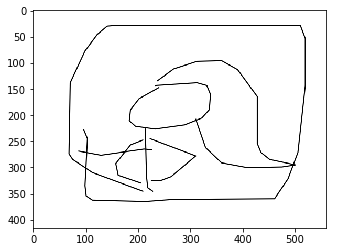

In [35]:
plt.imshow(Image.open('./data/test/not_car/The Mona Lisa_42.jpg'));

In [36]:
!ls data/train

car  not_car


# CNN

In [95]:
classifier = Sequential()

classifier.add(Convolution2D(32, (3 ,3), input_shape=(128, 128, 3), activation='relu'))
classifier.add(MaxPool2D(pool_size=(2, 2)))

classifier.add(Convolution2D(20, (3, 3), activation='relu'))
classifier.add(MaxPool2D(pool_size=(2, 2)))

classifier.add(Convolution2D(12, (3, 3), activation='relu'))
classifier.add(MaxPool2D(pool_size=(2, 2)))

classifier.add(Convolution2D(8, (3, 3), activation='relu'))
classifier.add(MaxPool2D(pool_size=(2, 2)))

classifier.add(Flatten())

classifier.add(Dense(activation='relu', units=128))
classifier.add(Dense(activation='sigmoid', units=1))

classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [96]:
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 61, 61, 20)        5780      
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 30, 30, 20)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 28, 28, 12)        2172      
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 14, 14, 12)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 12, 12, 8)         872       
__________

In [97]:
image_size = (128,128)
batch_size_chosen = 32

train_datagen = ImageDataGenerator(rescale=1/255,
                                   zoom_range=0.2,
                                   rotation_range = 15,
                                   horizontal_flip=True)
train_generator = train_datagen.flow_from_directory('data/train',
                                                    target_size=image_size,
                                                    batch_size=batch_size_chosen,
                                                    class_mode='binary')

test_datagen = ImageDataGenerator(rescale=1/255)
validation_generator = test_datagen.flow_from_directory('data/test',
                                                        target_size=image_size,
                                                        batch_size=batch_size_chosen,
                                                        class_mode='binary')

Found 47768 images belonging to 2 classes.
Found 23885 images belonging to 2 classes.


In [98]:
!rm -r logs/

In [99]:
es = keras.callbacks.EarlyStopping(monitor='val_loss',
                                   min_delta=0,
                                   patience=3,
                                   verbose=1,
                                   mode='auto',
                                   restore_best_weights=True)

ts = keras.callbacks.TensorBoard(log_dir='./logs',
                                 histogram_freq=0,
                                 batch_size=32,
                                 write_graph=True,
                                 write_grads=False,
                                 write_images=False,
                                 embeddings_freq=0,
                                 embeddings_layer_names=None,
                                 embeddings_metadata=None,
                                 embeddings_data=None,
                                 update_freq='epoch')

train_generator.class_indices

{'car': 0, 'not_car': 1}

In [100]:
classifier.fit_generator(train_generator,
                         steps_per_epoch=500,
                         epochs=30,
                         validation_data=validation_generator,
                         validation_steps=200,
                         workers=4,
                         callbacks=[es, ts])

Epoch 1/30
500/500 [==============================] - 53s 106ms/step - loss: 0.3492 - acc: 0.8461 - val_loss: 0.2374 - val_acc: 0.9067
Epoch 2/30
461/500 [==========================>...] - ETA: 3s - loss: 0.2506 - acc: 0.9018

KeyboardInterrupt: 

In [14]:
classifier.save('modele.h5')

In [16]:
model = load_model('modele.h5')

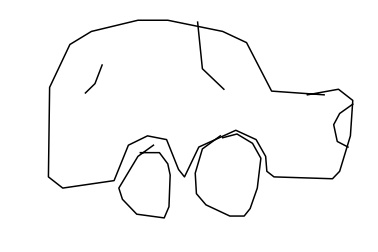

In [22]:
Image.open('./data/test/car/1000.jpg')

In [26]:
img = np.array(Image.open('./data/test/car/1000.jpg').convert('RGB').resize((128,128))).reshape(1,128,128,3)*1/255
model.predict_proba(img)

array([[0.00134879]], dtype=float32)

In [27]:
model.predict_classes(img.reshape(1,128,128,3)*1/255)

array([[0]], dtype=int32)